#1

In [1]:
contain_file_data = 'data/csv_files'


In [2]:
import pandas as pd
import numpy as np
import random
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

def covert_to_float(table: pd.DataFrame):
    for each_col in table.columns:
        if each_col[-1] in ['P', 'A']:
            table[each_col] = table[each_col].astype('float64') 
            ##print(table[each_col].dtypes)
    return table

def convert_dtype(table: pd.DataFrame):
    
    for each_col in table.columns:
        if table[each_col].dtypes.name in ['object', 'string']:# 
            table[each_col] = table[each_col].astype('string').astype('category')
    
    return table


In [3]:

table_train_static_0 = pd.read_csv(contain_file_data + '/train/train_static_0_0.csv')
table_train_static_0 = covert_to_float(table_train_static_0)

table_train_static_1 = pd.read_csv(contain_file_data + '/train/train_static_0_1.csv')
table_train_static_1 = covert_to_float(table_train_static_1)

Join_table = [table_train_static_0, table_train_static_1]
train_static = pd.concat(Join_table)


train_static_cb = pd.read_csv(contain_file_data + '/train/train_static_cb_0.csv')
train_static_cb = covert_to_float(train_static_cb)

train_base = pd.read_csv(contain_file_data + '/train/train_base.csv')
train_base = covert_to_float(train_base)

train_person_1 = pd.read_csv(contain_file_data + '/train/train_person_1.csv')
train_person_1 = covert_to_float(train_person_1)


train_credit_bureau_b_2 = pd.read_csv(contain_file_data + '/train/train_credit_bureau_b_2.csv')
train_base = covert_to_float(train_base)

/tmp/ipykernel_45303/1480878906.py:1: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  table_train_static_0 = pd.read_csv(contain_file_data + '/train/train_static_0_0.csv')
/tmp/ipykernel_45303/1480878906.py:4: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  table_train_static_1 = pd.read_csv(contain_file_data + '/train/train_static_0_1.csv')
/tmp/ipykernel_45303/1480878906.py:11: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  train_static_cb = pd.read_csv(contain_file_data + '/train/train_static_cb_0.csv')
/tmp/ipykernel_45303/1480878906.py:17: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  train_person_1 = pd.read_csv(contain_file_data + '/train/train_person_1.csv')


In [4]:
table_test_static_0 = pd.read_csv(contain_file_data + '/test/test_static_0_0.csv')
table_test_static_1 = pd.read_csv(contain_file_data + '/test/test_static_0_1.csv')
table_test_static_2 = pd.read_csv(contain_file_data + '/test/test_static_0_2.csv')
join_table_static = [table_test_static_0, table_test_static_1, table_test_static_2]
test_static =  pd.concat(join_table_static)

test_base = pd.read_csv(contain_file_data + '/test/test_base.csv')
test_base = covert_to_float(test_base)

test_static_cb = pd.read_csv(contain_file_data + '/test/test_static_cb_0.csv')
test_static_cb = covert_to_float(test_static_cb)

test_person_1 =  pd.read_csv(contain_file_data + '/test/test_person_1.csv')
test_person_1 = covert_to_float(test_person_1)

test_credit_bureau_b_2 = pd.read_csv(contain_file_data + '/test/test_credit_bureau_b_2.csv')
test_credit_bureau_b_2 = covert_to_float(test_credit_bureau_b_2)


#2

In [5]:

train_person_1_feats = train_person_1.loc[:, ['case_id', 'mainoccupationinc_384A', 'incometype_1044T']]
groupby_train_person_1_feats_1_idx = train_person_1_feats.groupby('case_id')['mainoccupationinc_384A'].idxmax()
train_person_1_feats_1 = train_person_1_feats.loc[groupby_train_person_1_feats_1_idx]
train_person_1_feats_1['incometype_1044T'] = train_person_1_feats_1['incometype_1044T'] == 'SELFEMPLOYED' #1.1
train_person_1_feats_1.columns = ['case_id', 'mainoccupationinc_384A_max', 'mainoccupationinc_384A_any_selfemployed']
print(train_person_1_feats_1.shape)

train_person_1_feats_2 = train_person_1.loc[:, ['case_id', 'num_group1', 'housetype_905L']] 
train_person_1_feats_2 = train_person_1_feats_2.loc[train_person_1_feats_2['num_group1'] == 0] #1.2
train_person_1_feats_2 = train_person_1_feats_2.drop('num_group1', axis = 1)
train_person_1_feats_2.columns = ['case_id', 'person_housetype ']
print(train_person_1_feats_2.shape)

train_cred_bureau_b_2= train_credit_bureau_b_2.loc[:, ['case_id', 'pmts_pmtsoverdue_635A', 'pmts_dpdvalue_108P']]
groupby_train_credit_bureau_b_2_idx = train_cred_bureau_b_2.groupby('case_id')['pmts_pmtsoverdue_635A'].idxmax()
train_credit_bureau_b_2_feats = train_cred_bureau_b_2.loc[groupby_train_credit_bureau_b_2_idx.dropna()]
train_credit_bureau_b_2_feats['pmts_dpdvalue_108P'] = train_credit_bureau_b_2_feats['pmts_dpdvalue_108P']> 31
train_credit_bureau_b_2_feats.columns = ['case_id', 'pmts_pmtsoverdue_635A_max', 'pmts_dpdvalue_108P_over31']
print(train_credit_bureau_b_2_feats.shape)

(1526659, 3)
(1526659, 2)
(36415, 3)


In [6]:
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A"):
        selected_static_cols.append(col)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A"):
        selected_static_cb_cols.append(col)


    
data = train_base.merge(
    train_static[['case_id'] + selected_static_cols], how="left", on="case_id"
).merge(
    train_static_cb[['case_id'] + selected_static_cb_cols], how="left", on="case_id"
).merge(
    train_person_1_feats_1, how="left", on="case_id"
).merge(
    train_person_1_feats_2, how="left", on="case_id"
).merge(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)
print(train_person_1_feats_2)

         case_id person_housetype 
0              0               NaN
4              1               NaN
9              2               NaN
14             3               NaN
17             4               NaN
...          ...               ...
2973984  2703450             OWNED
2973985  2703451               NaN
2973987  2703452               NaN
2973988  2703453               NaN
2973990  2703454               NaN

[1526659 rows x 2 columns]


In [7]:
test_person_1_feats = test_person_1.loc[:, ['case_id', 'mainoccupationinc_384A', 'incometype_1044T']]
groupby_test_person_1_feats_1_idx = test_person_1_feats.groupby('case_id')['mainoccupationinc_384A'].idxmax()
test_person_1_feats_1 = test_person_1_feats.loc[groupby_test_person_1_feats_1_idx]
test_person_1_feats_1['incometype_1044T'] = test_person_1_feats_1['incometype_1044T'] == 'SELFEMPLOYED' #1.1
test_person_1_feats_1.columns = ['case_id', 'mainoccupationinc_384A_max', 'mainoccupationinc_384A_any_selfemployed']
print(test_person_1_feats_1.shape)

test_person_1_feats_2 = test_person_1.loc[:, ['case_id', 'num_group1', 'housetype_905L']] 
test_person_1_feats_2 = test_person_1_feats_2.loc[test_person_1_feats_2['num_group1'] == 0] #1.2
test_person_1_feats_2 = test_person_1_feats_2.drop('num_group1', axis = 1)
print(test_person_1_feats_2.shape)

test_cred_bureau_b_2= test_credit_bureau_b_2.loc[:, ['case_id', 'pmts_pmtsoverdue_635A', 'pmts_dpdvalue_108P']]
groupby_test_credit_bureau_b_2_idx = test_cred_bureau_b_2.groupby('case_id')['pmts_pmtsoverdue_635A'].idxmax()
test_credit_bureau_b_2_feats = test_cred_bureau_b_2.loc[groupby_test_credit_bureau_b_2_idx]
test_credit_bureau_b_2_feats['pmts_dpdvalue_108P'] = test_credit_bureau_b_2_feats['pmts_dpdvalue_108P']> 31
print(test_credit_bureau_b_2_feats.shape)

(3, 3)
(3, 2)
(1, 3)


In [8]:
data_submission = train_base.merge(
    test_static[["case_id"]+selected_static_cols], how="left", on="case_id"
).merge(
    test_static_cb[["case_id"]+selected_static_cb_cols], how="left", on="case_id"
).merge(
    test_person_1_feats_1, how="left", on="case_id"
).merge(
    test_person_1_feats_2, how="left", on="case_id"
).merge(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)


In [9]:
data_shuffe = data.sample(frac = 1)
case_ids_train, case_ids_test = train_test_split(data_shuffe, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

def separate_df(case_ids):
    return(
        case_ids.filter(items=["case_id", "WEEK_NUM", "target"]),
        case_ids.filter(items=cols_pred),
        case_ids.filter(items=["target"])
    )

base_train, X_train, y_train = separate_df(case_ids_train)
base_valid, X_valid, y_valid = separate_df(case_ids_valid)
base_test, X_test, y_test = separate_df(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_dtype(df)
print(df.shape)



(305332, 35)


In [10]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 35)
Valid: (305332, 35)
Test: (305332, 35)


None


ValueError: x and y can be no greater than 2D, but have shapes (101,) and (101, 1, 1)

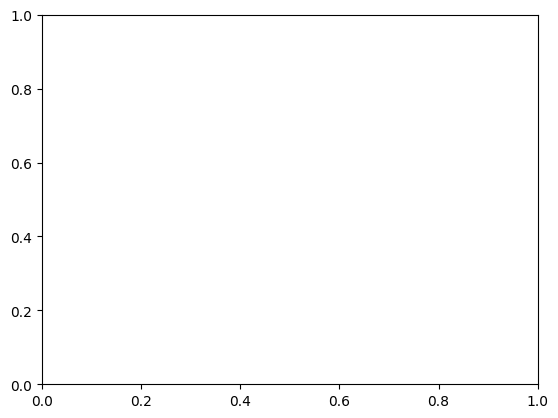

In [11]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))


his_m = []
his_loss = []
def logistic_sigmoid_regression(X, Y, w_init,  epoch, learn_rate):
    
    y_predic = sigmoid(np.dot(X, w_init.T))
    parl_der = np.dot((y_predic- Y).T, X)
    for i in range(epoch + 1):
        w_init -= learn_rate*parl_der
        y_predic = sigmoid(np.dot(X, w_init.T))
        loss = - (np.dot(Y.T, np.log(y_predic)) + np.dot((1-Y).T,np.log(1-y_predic) ))
        his_loss.append(loss)
print(logistic_sigmoid_regression(X_train, y_train, np.random.rand(1,35), 100, 0.0001))

plt.plot(his_loss)
plt.show()